In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [26]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm

In [12]:
############################################
sweep_root = "../../results/sweep-24-trials"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [13]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

In [14]:
sweep_results = read_sweep_results(sweep_path)
list(sweep_results.keys())

--> ../../results/sweep-24-trials/gptj
    --> ../../results/sweep-24-trials/gptj/person_occupation
        --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745
            --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745/person_occupation.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745/args-20230606-211709.json
        --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106
            --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106/args-20230607-012240.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106/person_occupation.json
        --> ../../results/sweep-24-trials/gptj/person_occupation/2_person_occupation_seed_88810
            --> ../../results/sweep-24-trials/gptj/person_occupation/2_person_occupation_seed_88810/args-202306

['person plays instrument',
 'person occupation',
 'landmark in country',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'city in country',
 'food from country',
 'company hq',
 'occupation age',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'person native language',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'landmark on continent',
 'person lead singer of band',
 'task person type',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective superlative',
 'adjective comparative',
 'univ degree gender']

In [15]:
relation = "country capital city"
relation_result = relation_from_dict(sweep_results[relation])

In [16]:
efficacy = relation_result.best_by_efficacy()
print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
print("recall:", efficacy.recall)
print("efficacy:", efficacy.efficacy)

faithfulness = relation_result.best_by_faithfulness()
print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
print("recall:", faithfulness.recall)
print("efficacy:", faithfulness.efficacy)

best by efficacy =>  layer=4, beta=0.19, rank=53
recall: 0.95 ± 0.01
efficacy: 0.97 ± 0.01
best by faithfulness => layer=2, beta=0.22, rank=58
recall: 0.96 ± 0.01
efficacy: 0.93 ± 0.02


In [21]:
def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color='darkblue', linewidth=3)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color='lightblue', alpha=0.5)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    test_samples = np.array(test_samples)
    trial_info = f"[{test_samples.mean():.2f} ± {test_samples.std():.2f}]"
    canvas.set_title(f"{relation_result.relation_name} n_trials={len(test_samples)} {trial_info}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

<Axes: title={'center': 'country capital city n_trials=24 [13.25 ± 0.88]\nefficacy => h_layer: 4, beta: 0.19, rank: 52.92, efficacy: 0.97'}, xlabel='Layer', ylabel='efficacy'>

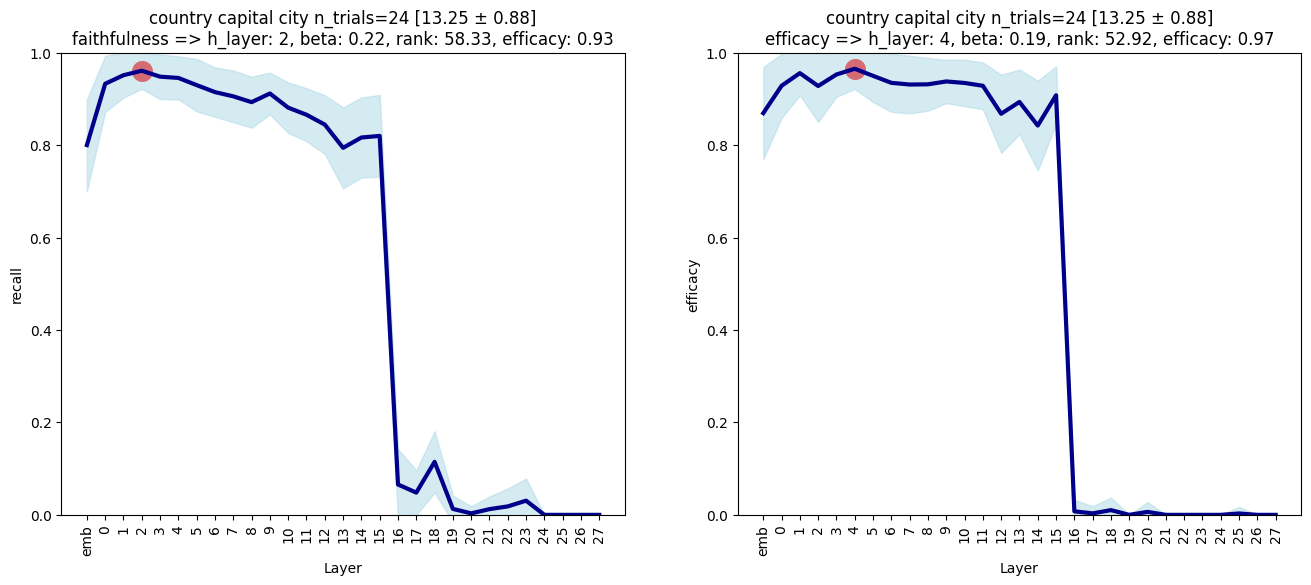

In [22]:
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")

In [23]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)
failed_relations

['characteristic gender',
 'company CEO',
 'name gender',
 'occupation gender',
 'person university',
 'president birth year',
 'president election year']

In [ ]:
############################################
efficacy_root = "../../results/efficacy_baselines"
############################################

efficacy_path = f"{efficacy_root}/{model_name}"

In [ ]:
def read_efficacy_baseline_results(sweep_path):
    efficacy_baseline_results = {}

    for relation_folder in os.listdir(sweep_path):
        cur_sweep = f"{sweep_path}/{relation_folder}"
        if "results_all.json" not in os.listdir(cur_sweep):
            continue
        with open(f"{cur_sweep}/results_all.json") as f:
            res = json.load(f)["relations"]
            if(len(res) == 0 or len(res[0]["trials"]) ==  0):
                continue
            res = res[0]
            efficacy_baseline_results[res["relation_name"]] = res
    return efficacy_baseline_results

efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

print(len(efficacy_baseline_results))
list(efficacy_baseline_results.keys())

In [ ]:
from src.metrics import AggregateMetric

In [ ]:
def parse_efficacy_baseline_results(efficacy_result):
    layerwise_results = {}
    for trial in efficacy_result["trials"]:
        for layer in trial["layerwise_baseline_results"]:
            layer_name = layer["layer"]
            if layer_name not in layerwise_results:
                layerwise_results[layer_name] = {
                    edit_type: [] for edit_type in layer["results"].keys()
                }
                layerwise_results[layer_name]
            for edit_type in layer["results"].keys():
                layerwise_results[layer_name][edit_type].append(layer['results'][edit_type])
    
    for layer_name in layerwise_results.keys():
        for edit_type in layerwise_results[layer_name].keys():
            layerwise_results[layer_name][edit_type] = AggregateMetric.aggregate(layerwise_results[layer_name][edit_type])
        
    return {
        "relation_name": efficacy_result["relation_name"],
        "layerwise_result": layerwise_results
    }


parse_efficacy_baseline_results(
    efficacy_baseline_results["country capital city"]
)

In [ ]:
color_dict = {
    "low_rank_pinv": "darkblue",
    "hidden_baseline": "darkgreen",
    "embed_baseline": "darkred",
    "hidden_baseline_z": "orange"
}

def plot_efficacy_baseline(ax, efficacy_result):
    layerwise_result = efficacy_result["layerwise_result"]
    layers = list(layerwise_result.keys())
    edit_types = list(layerwise_result[layers[0]].keys())

    for edit_type in edit_types:
        ax.plot(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean for layer in layers],
            label=edit_type,
            color=color_dict[edit_type],
            alpha=0.7,
            linestyle='--'
        )
        ax.fill_between(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean - layerwise_result[layer][edit_type].stdev for layer in layers],
            [layerwise_result[layer][edit_type].mean + layerwise_result[layer][edit_type].stdev for layer in layers],
            alpha=0.1,
            color=color_dict[edit_type]
        )
    ax.set_xticks(range(len(layers)))
    ax.set_xticklabels(layers)
    ax.legend()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Efficacy")
    if(ax.get_title() == ""):
        ax.set_title(efficacy_result["relation_name"])



efficacy_result = parse_efficacy_baseline_results(
    efficacy_baseline_results["country capital city"]
)

fig, ax = plt.subplots(figsize=(10, 5))
plot_efficacy_baseline(ax, efficacy_result)

In [ ]:
relation_result = parse_results(sweep_results['country capital city'])

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")
plot_efficacy_baseline(ax[1], efficacy_result)

fig.show()

In [ ]:
# ranks = {
#     layer : layer_summary.rank.values
#     for layer, layer_summary in relation_result.by_layer().items()
# }
# ranks

In [27]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in tqdm(interested_dataset.relations):
    if relation.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation.name])
    if len(relation_result.trials) < 3:
        print(f"skipping {relation.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

skipping occupation age, not enough trials, : [23]
skipping person father, not enough trials, : [12]
skipping star constellation name, not enough trials, : [11, 11]


0 univ degree gender
1 name birthplace
2 name religion
3 person native language
4 fruit inside color


/tmp/ipykernel_593859/297102453.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5 fruit outside color
6 object superclass
7 substance phase of matter
8 task person type
9 task done by tool
10 word sentiment
11 work location
12 city in country
13 company hq
14 country capital city
15 country currency
16 country language
17 country largest city
18 food from country
19 landmark in country
20 landmark on continent
21 person lead singer of band
22 person mother
23 person occupation
24 person plays instrument
25 person sport position
26 plays pro sport
27 pokemon evolution
28 product by company
29 superhero archnemesis
30 superhero person
31 adjective antonym
32 adjective comparative
33 adjective superlative
34 verb past tense
35 word first letter
36 word last letter


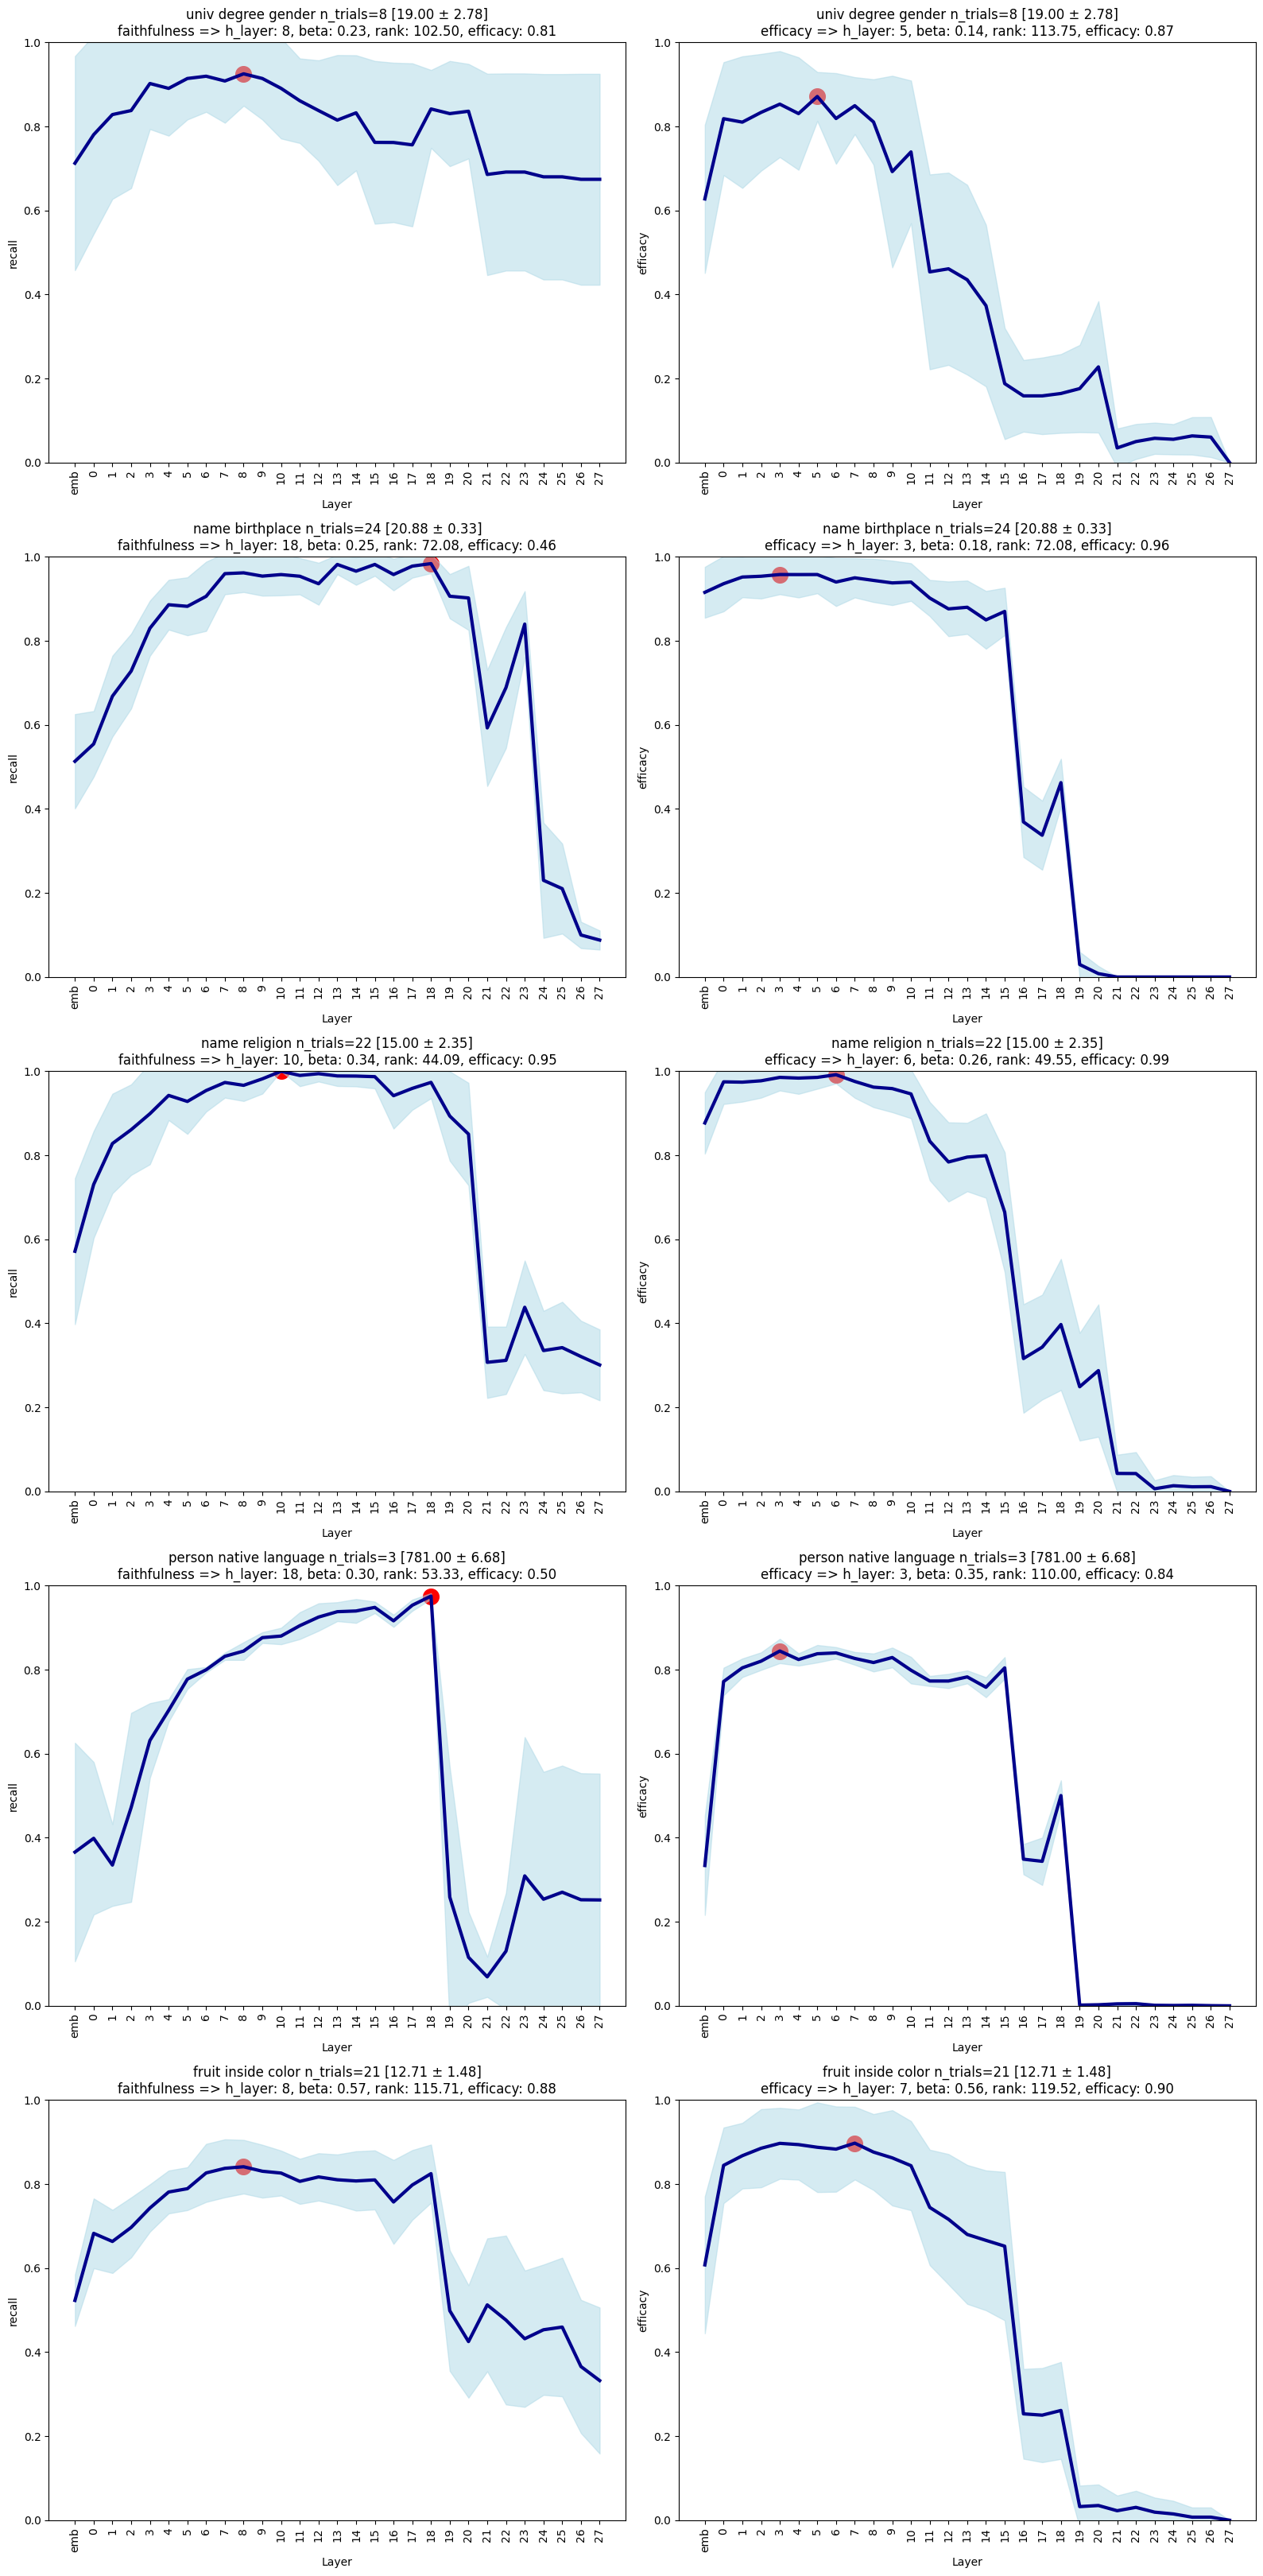

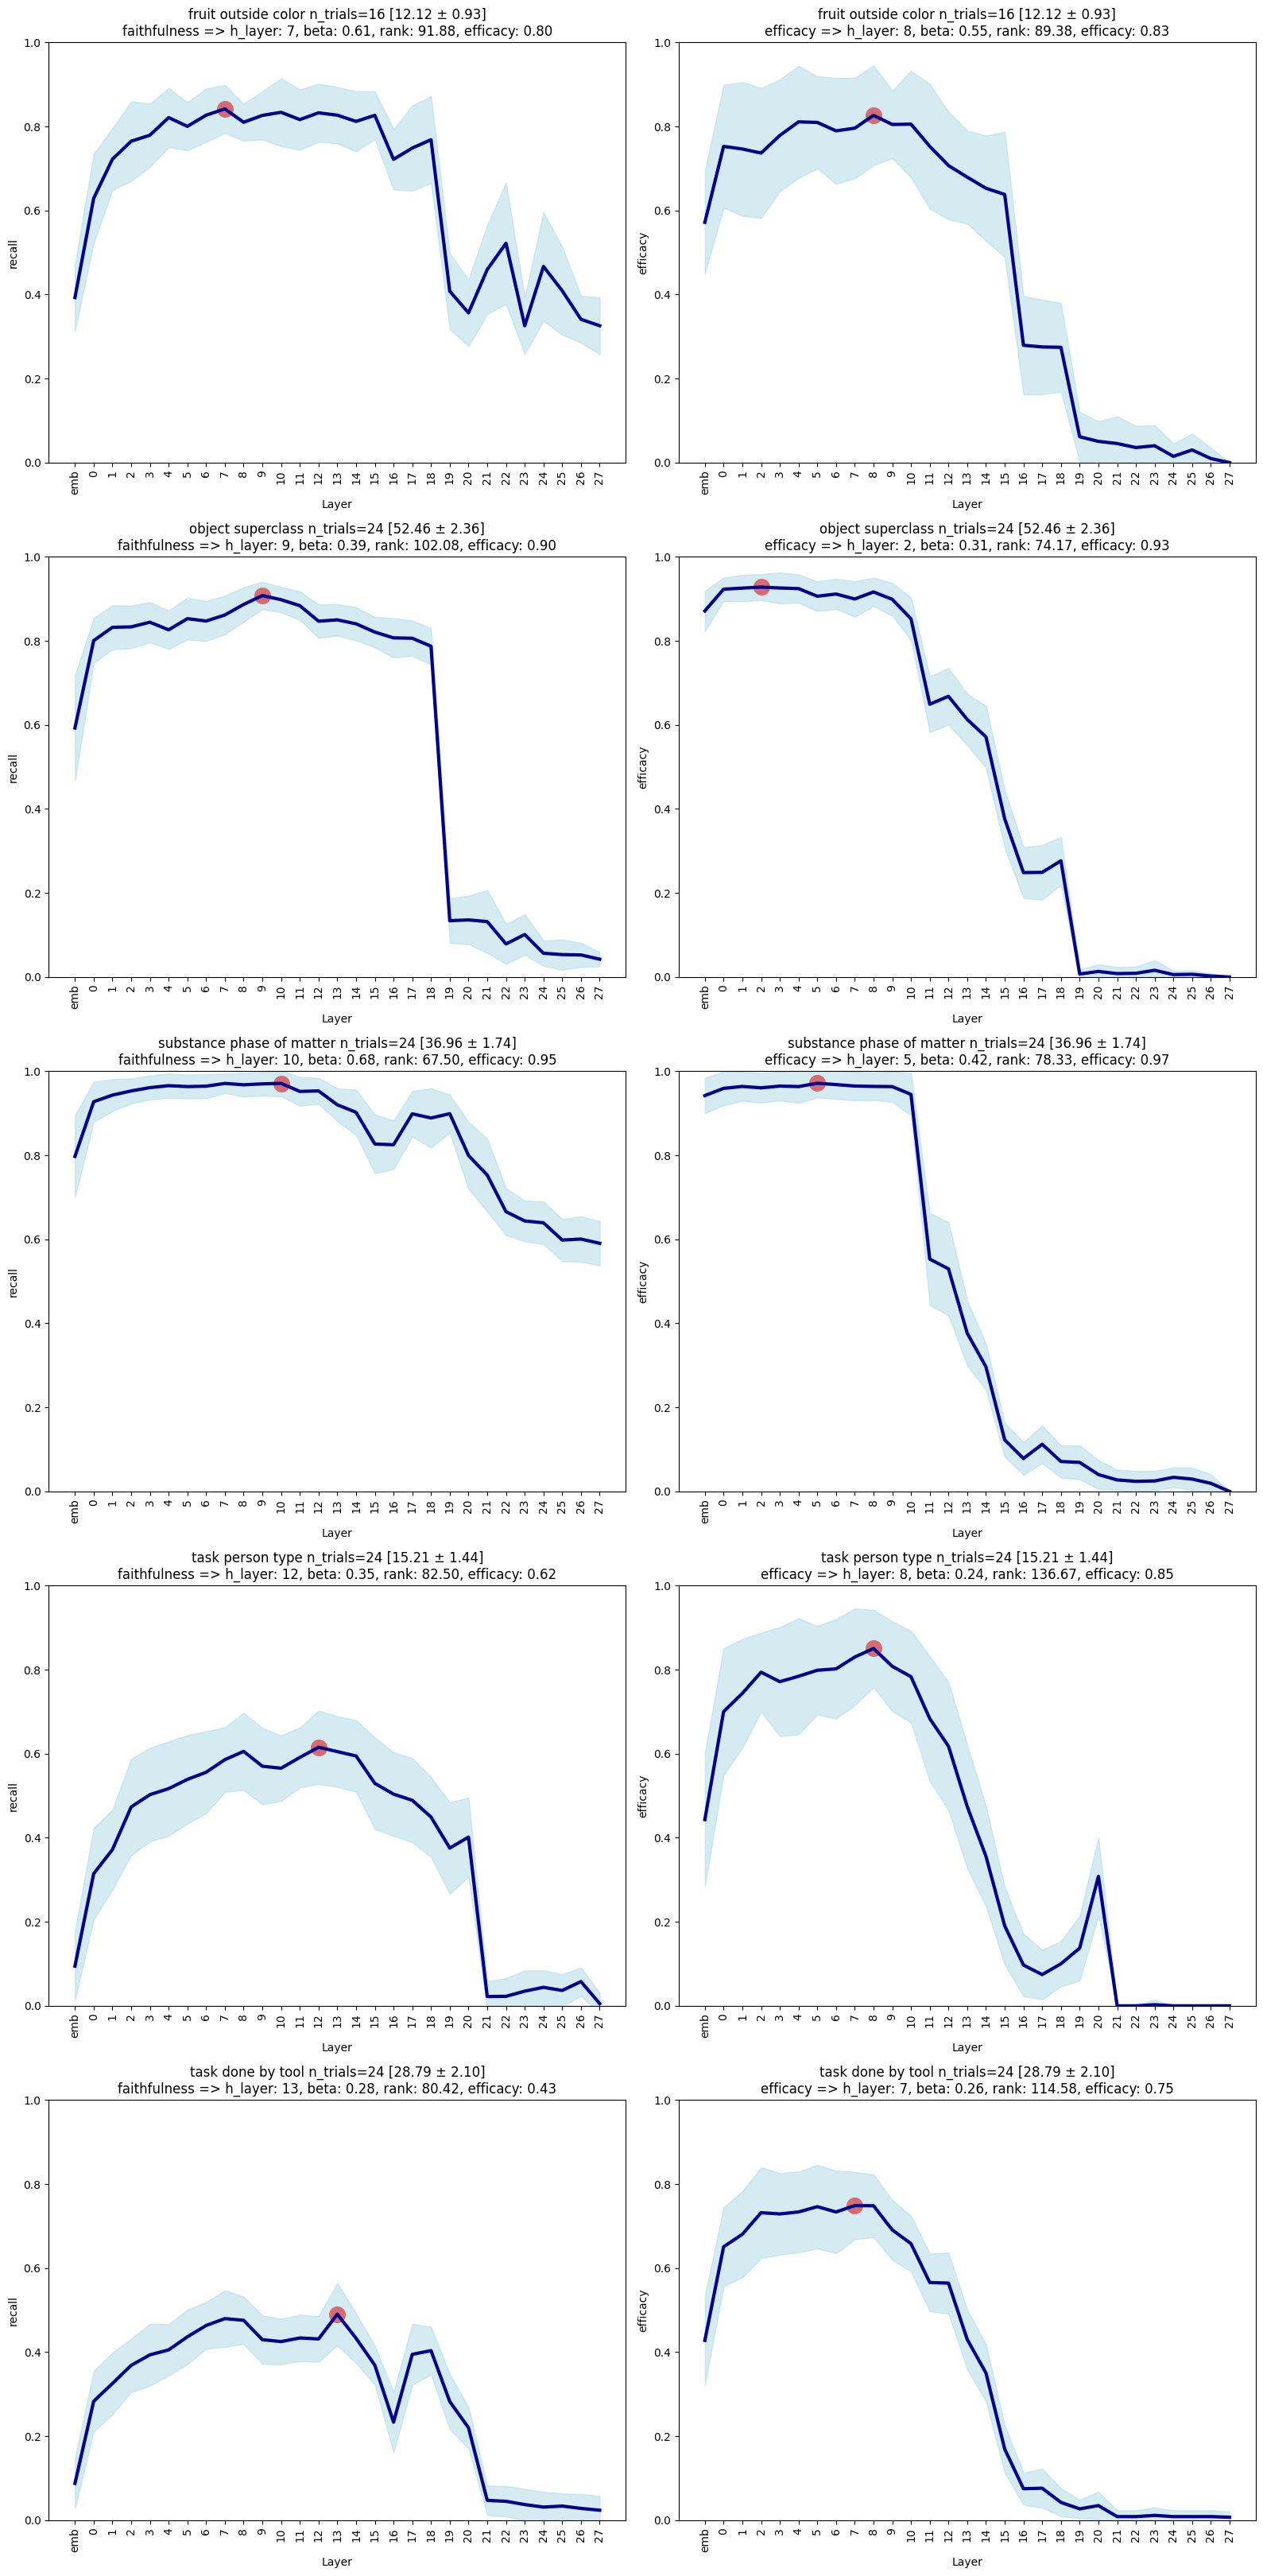

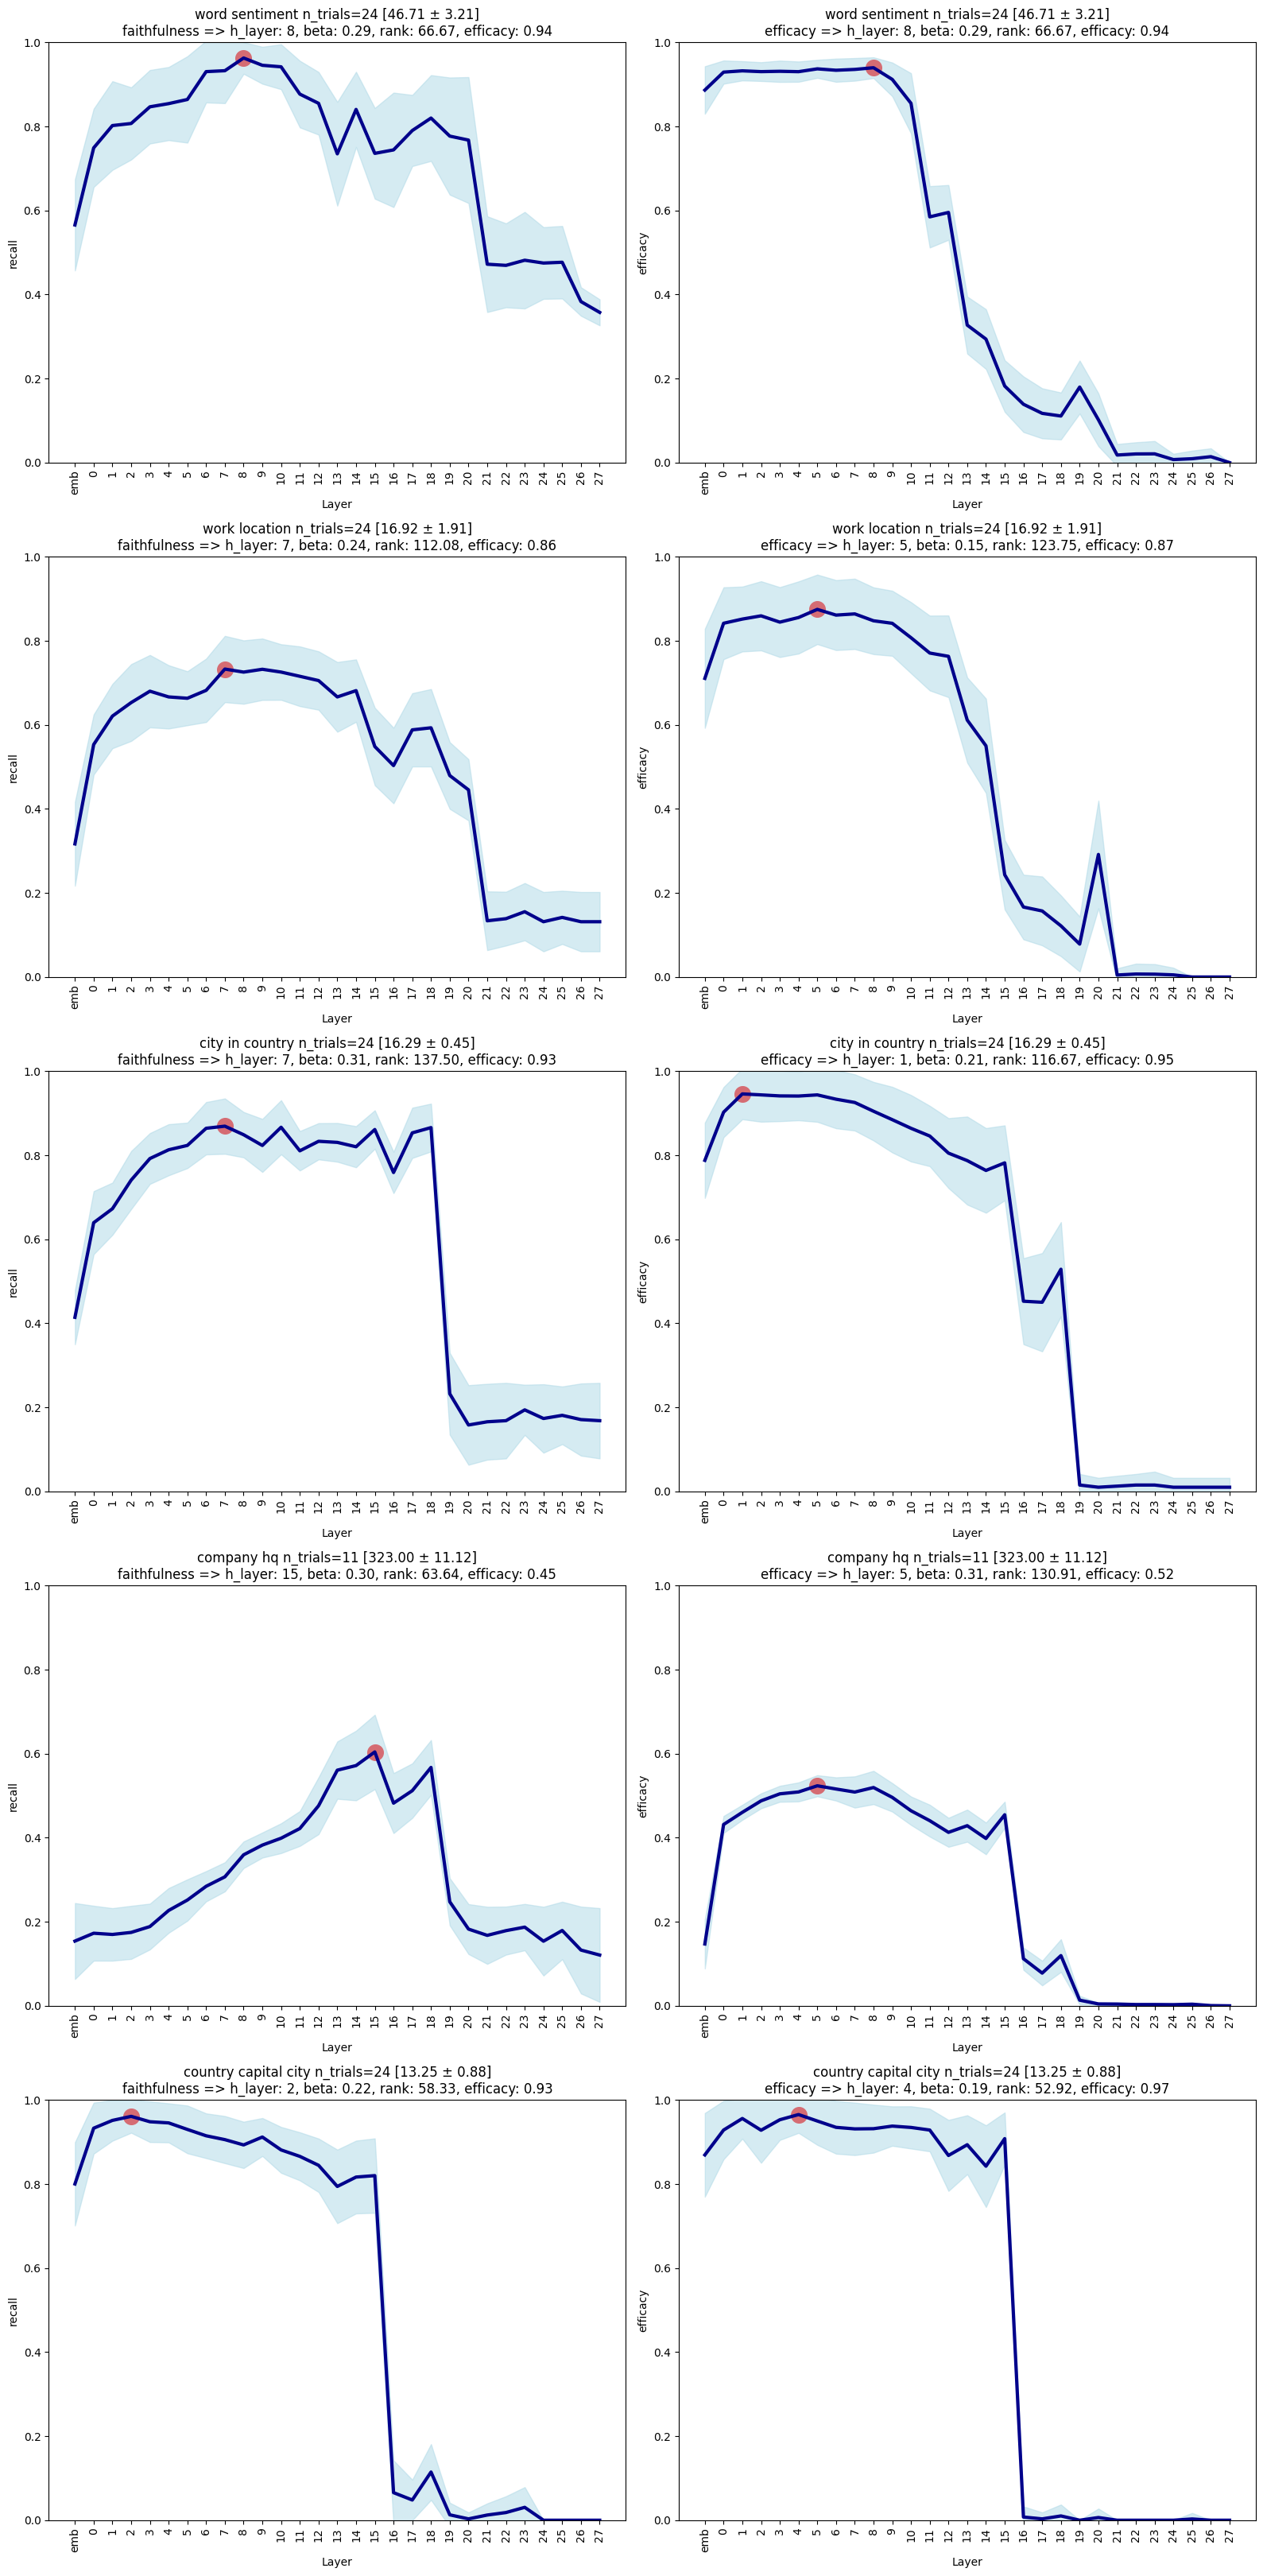

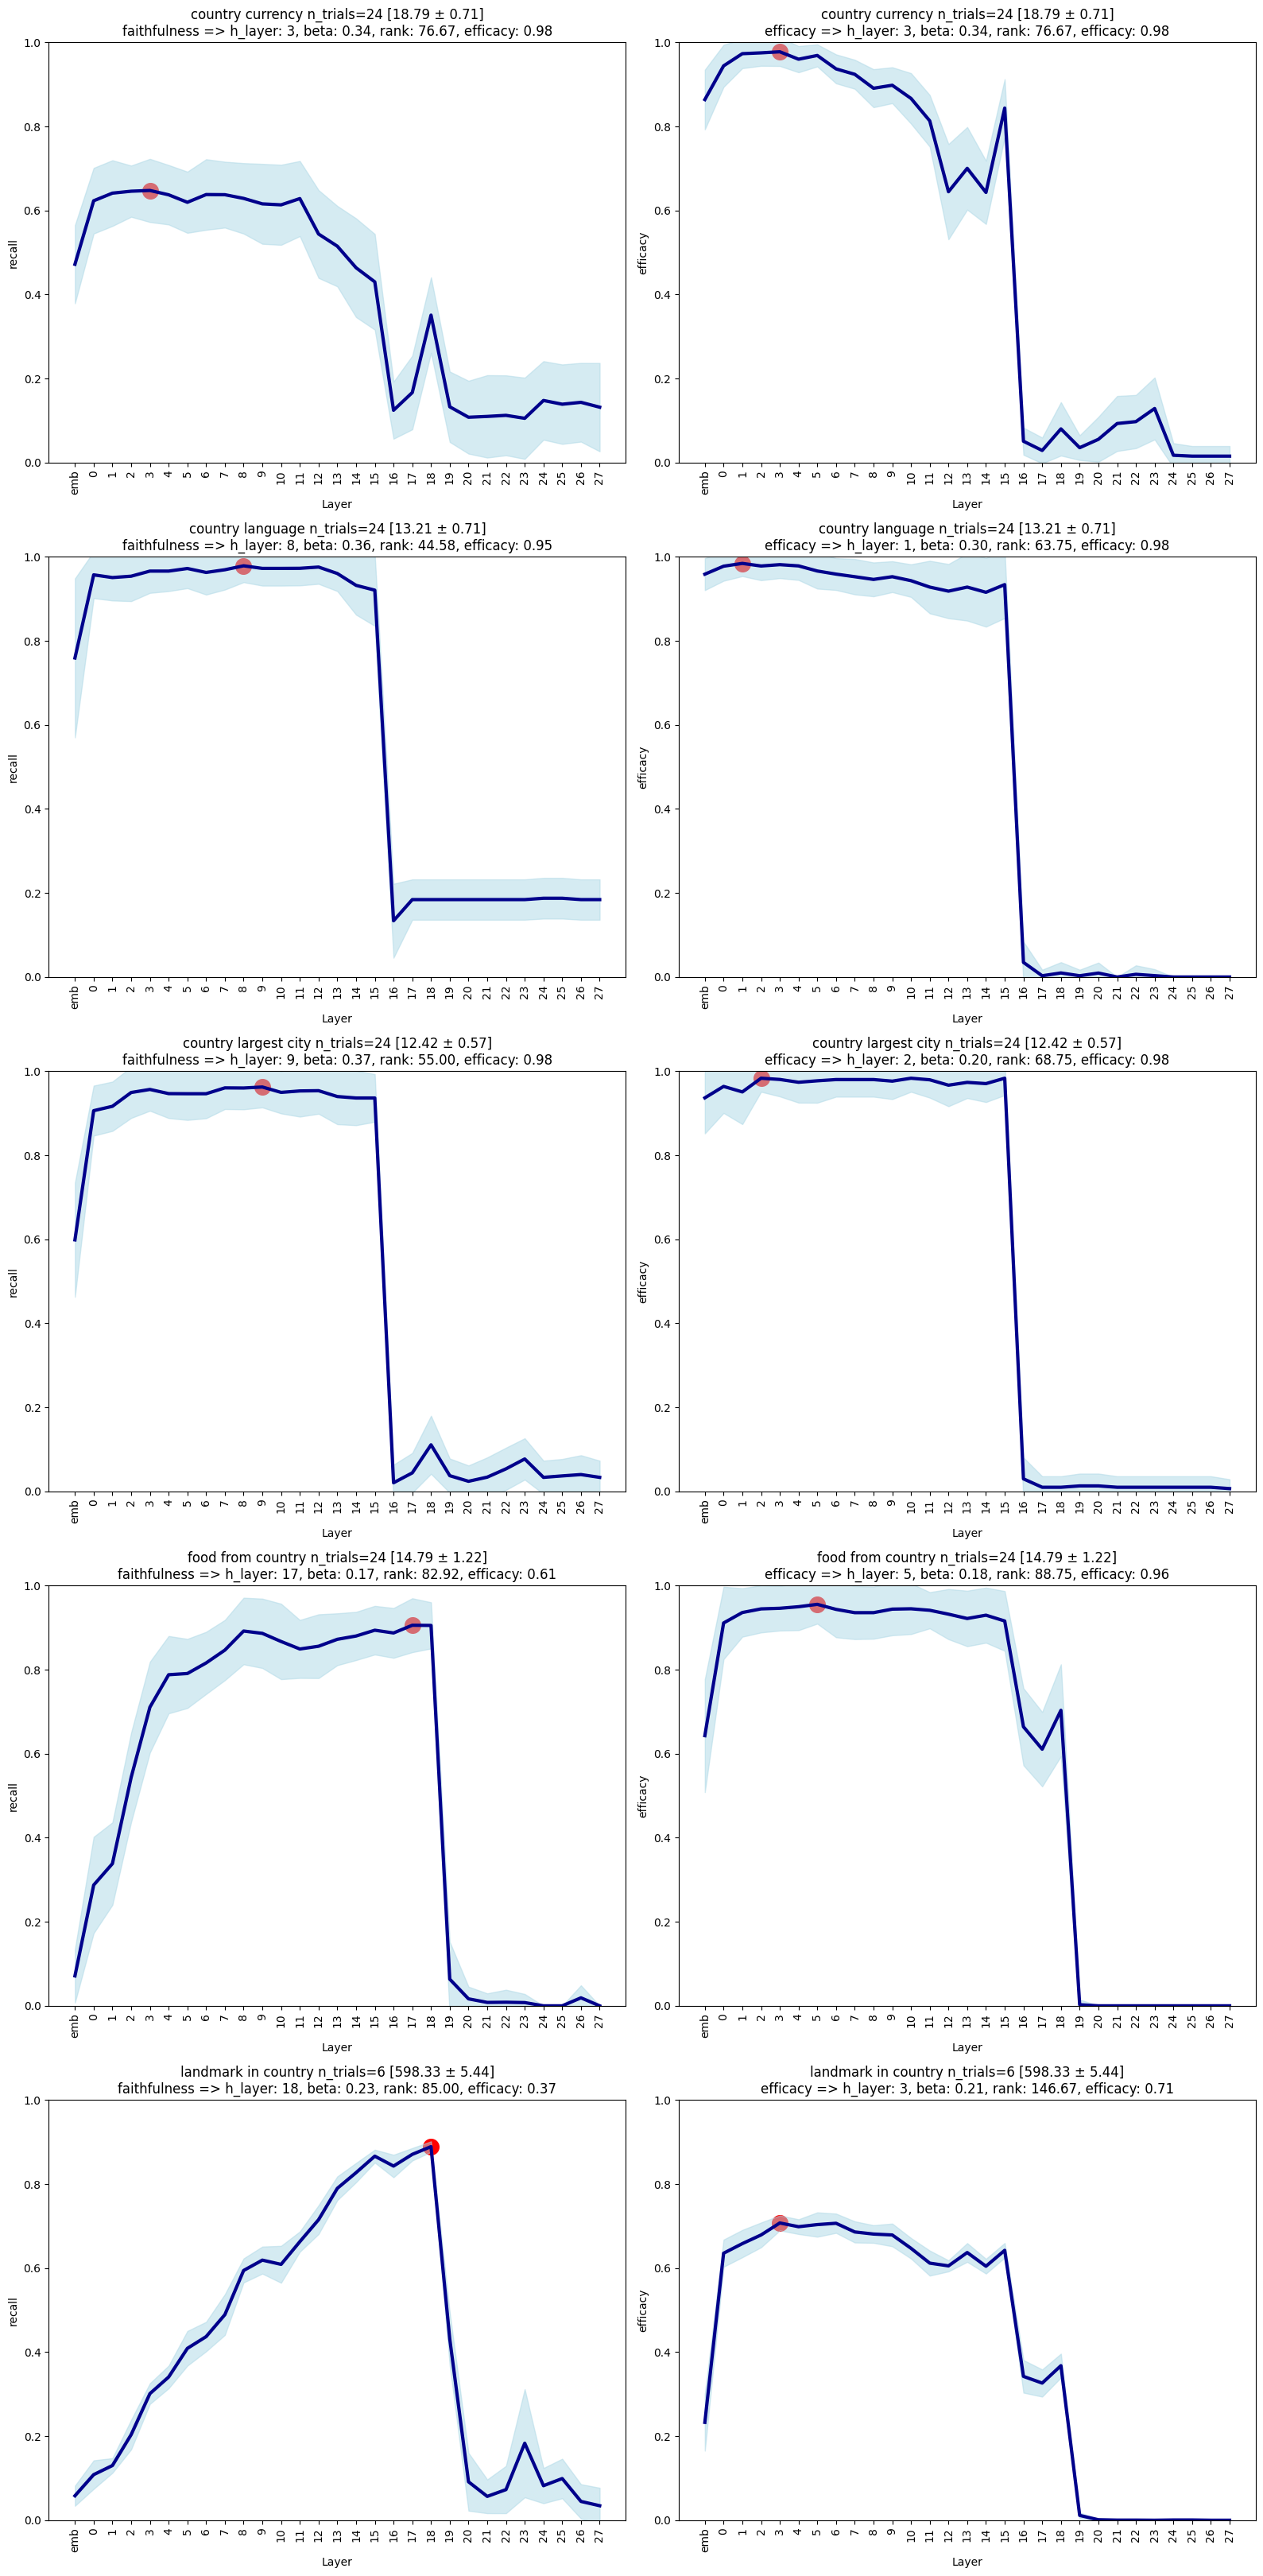

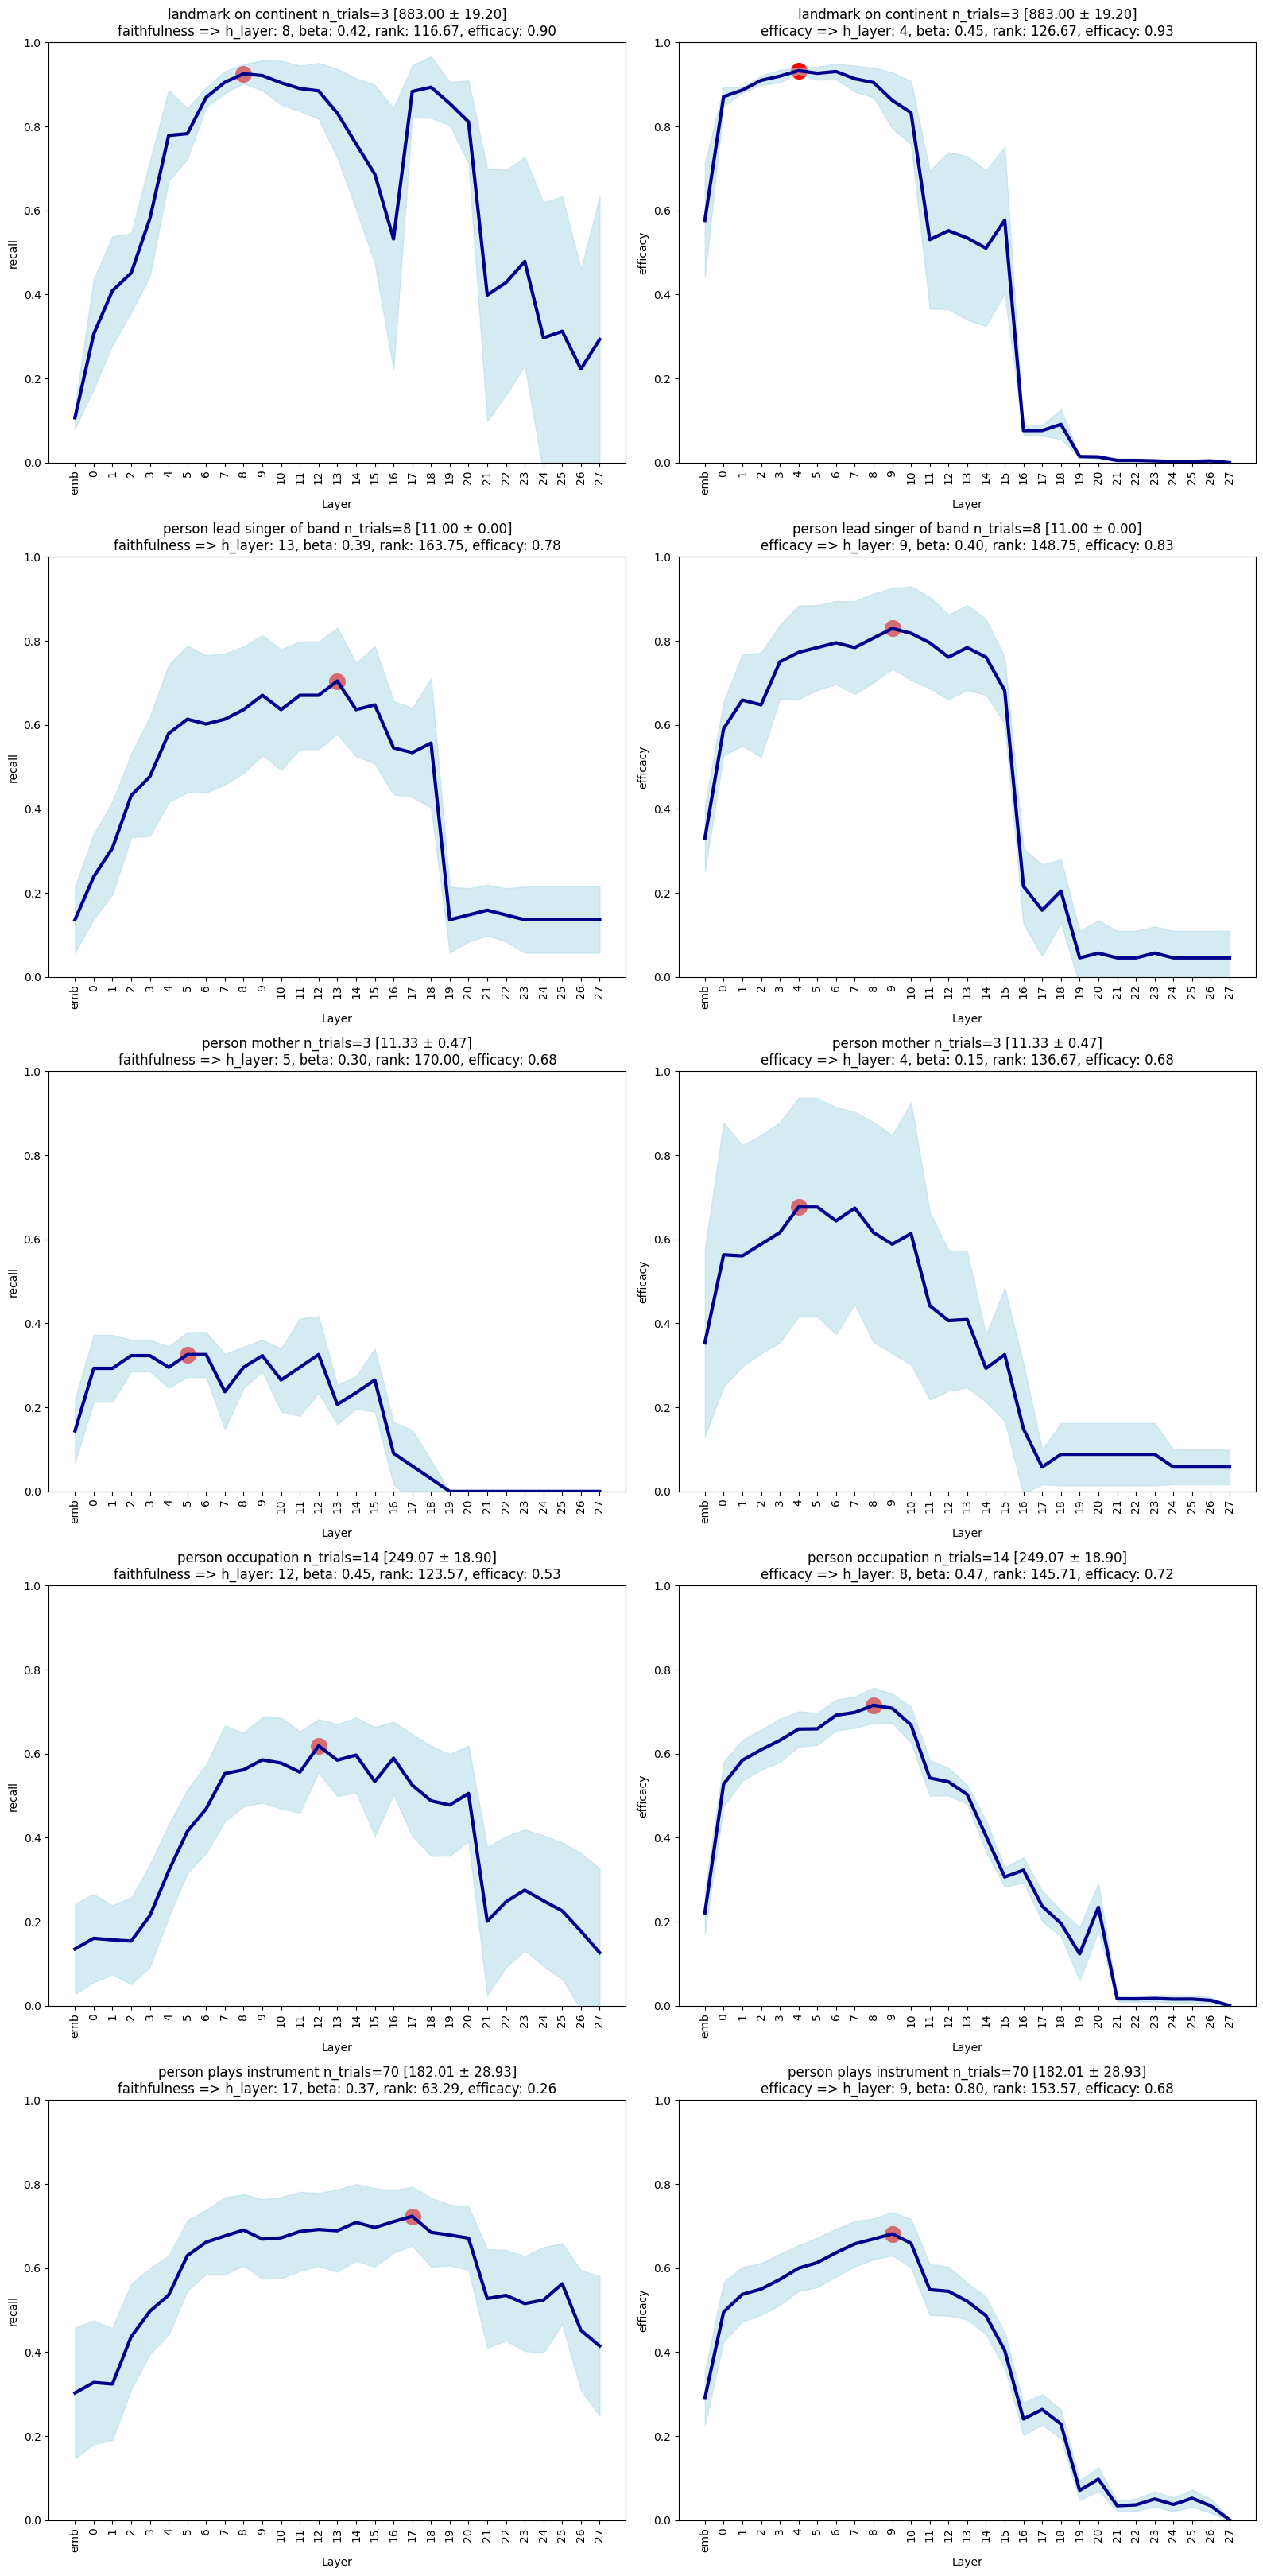

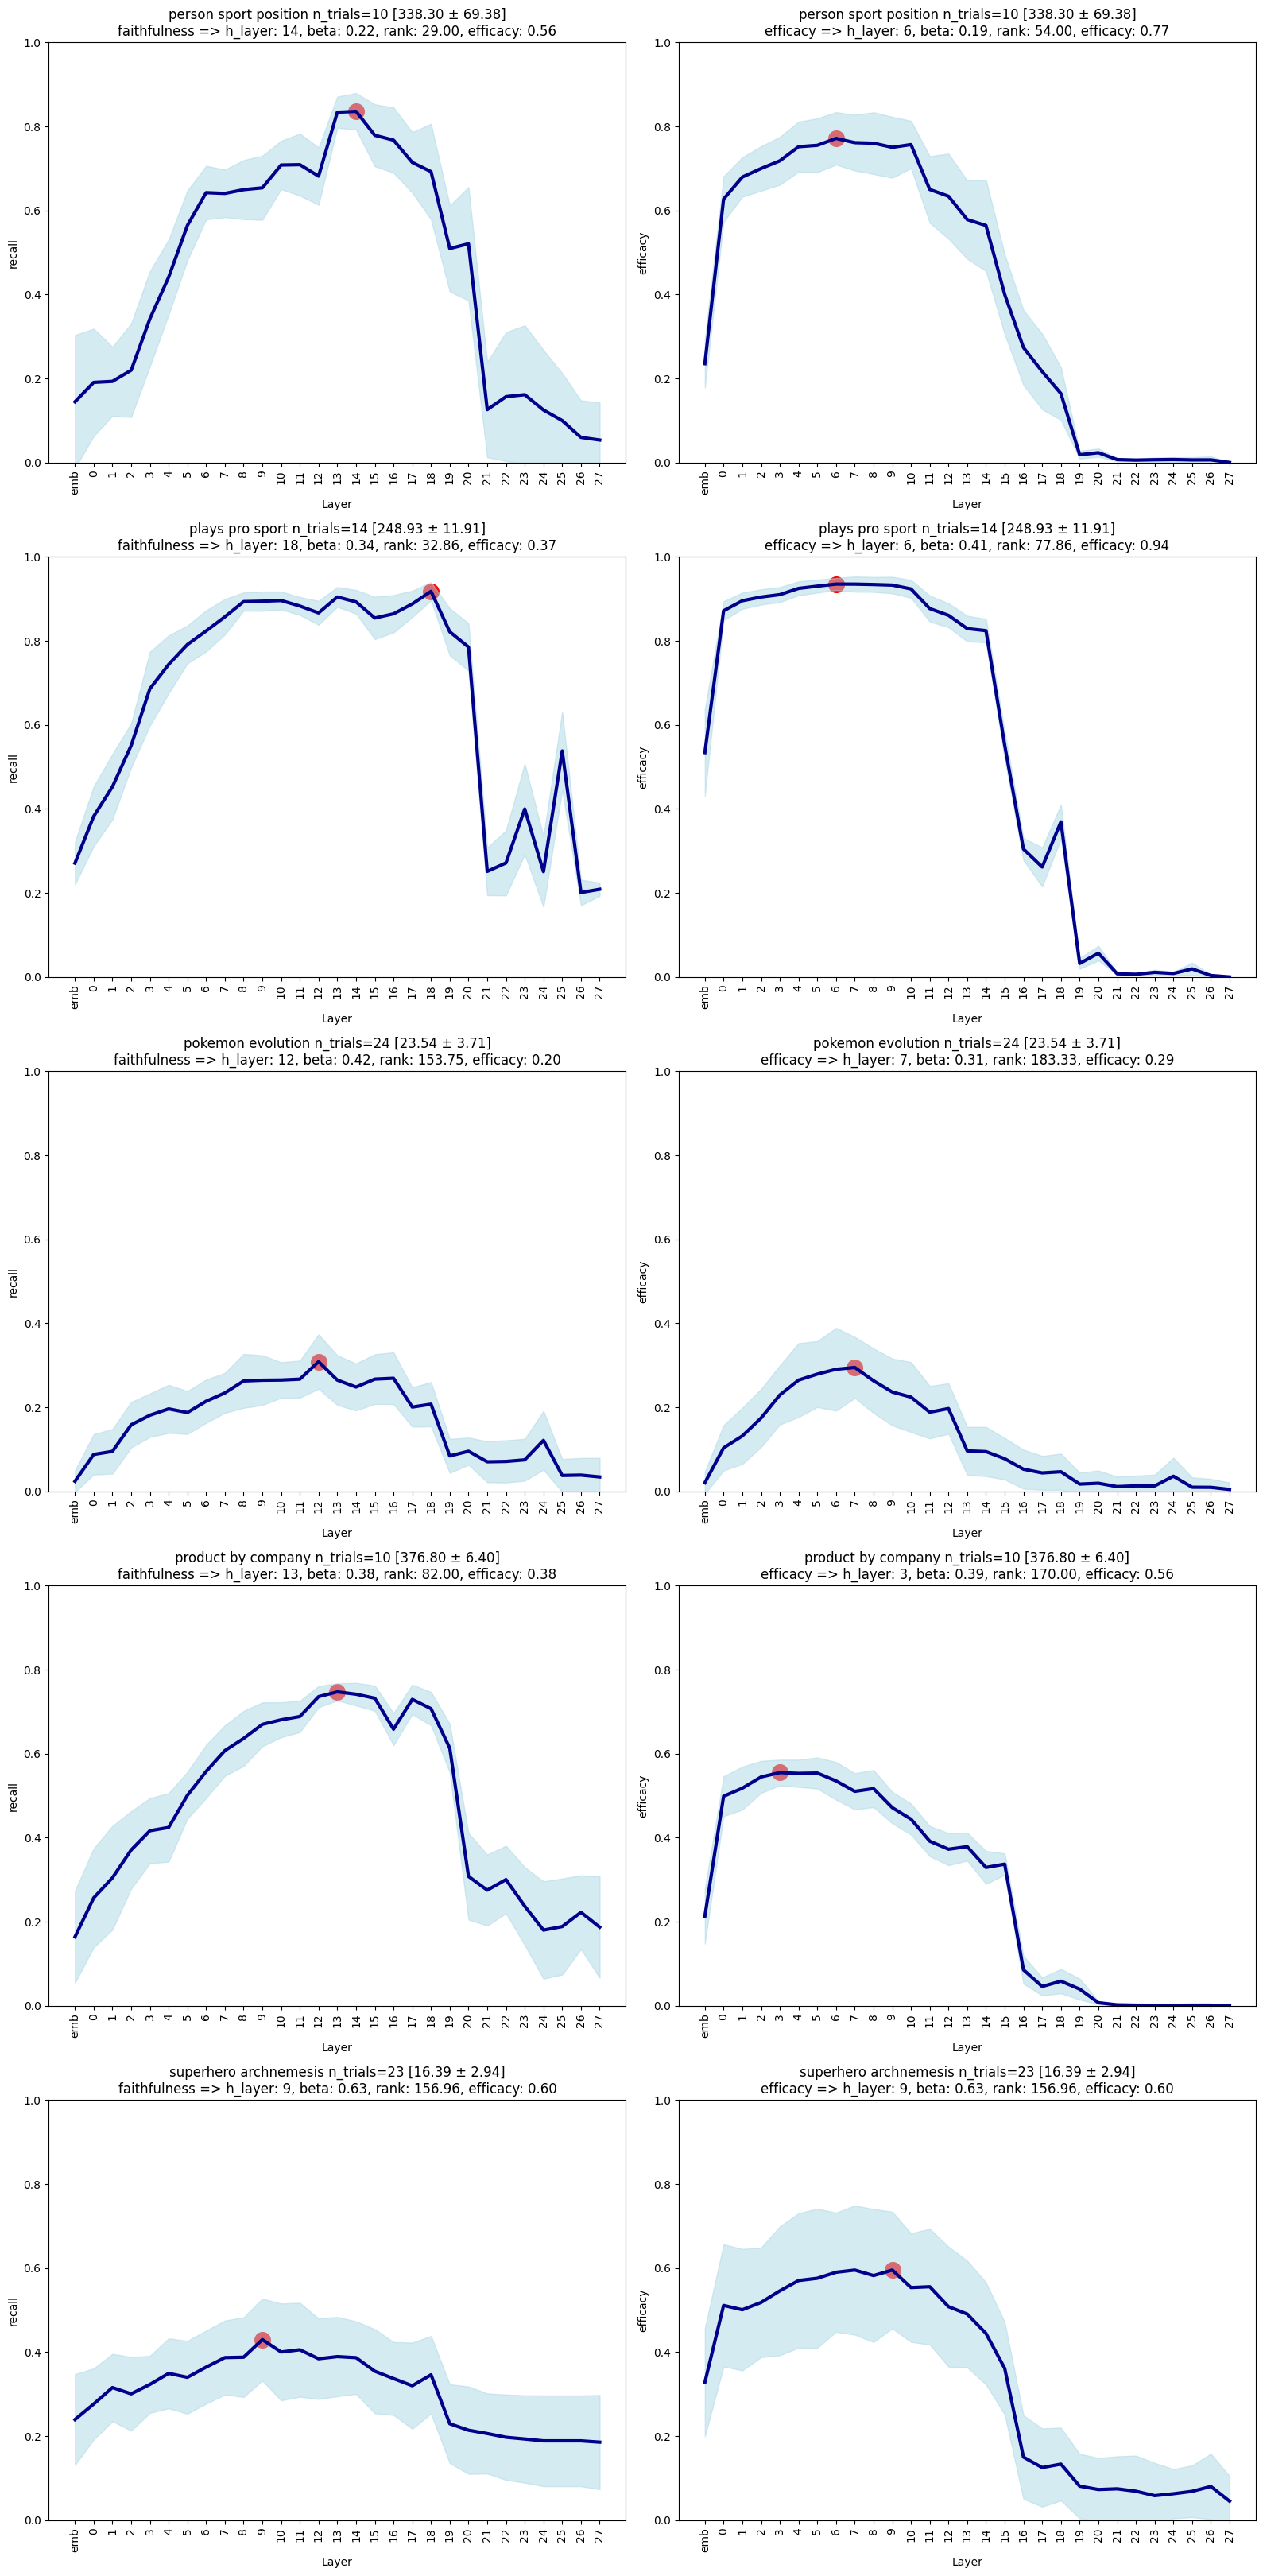

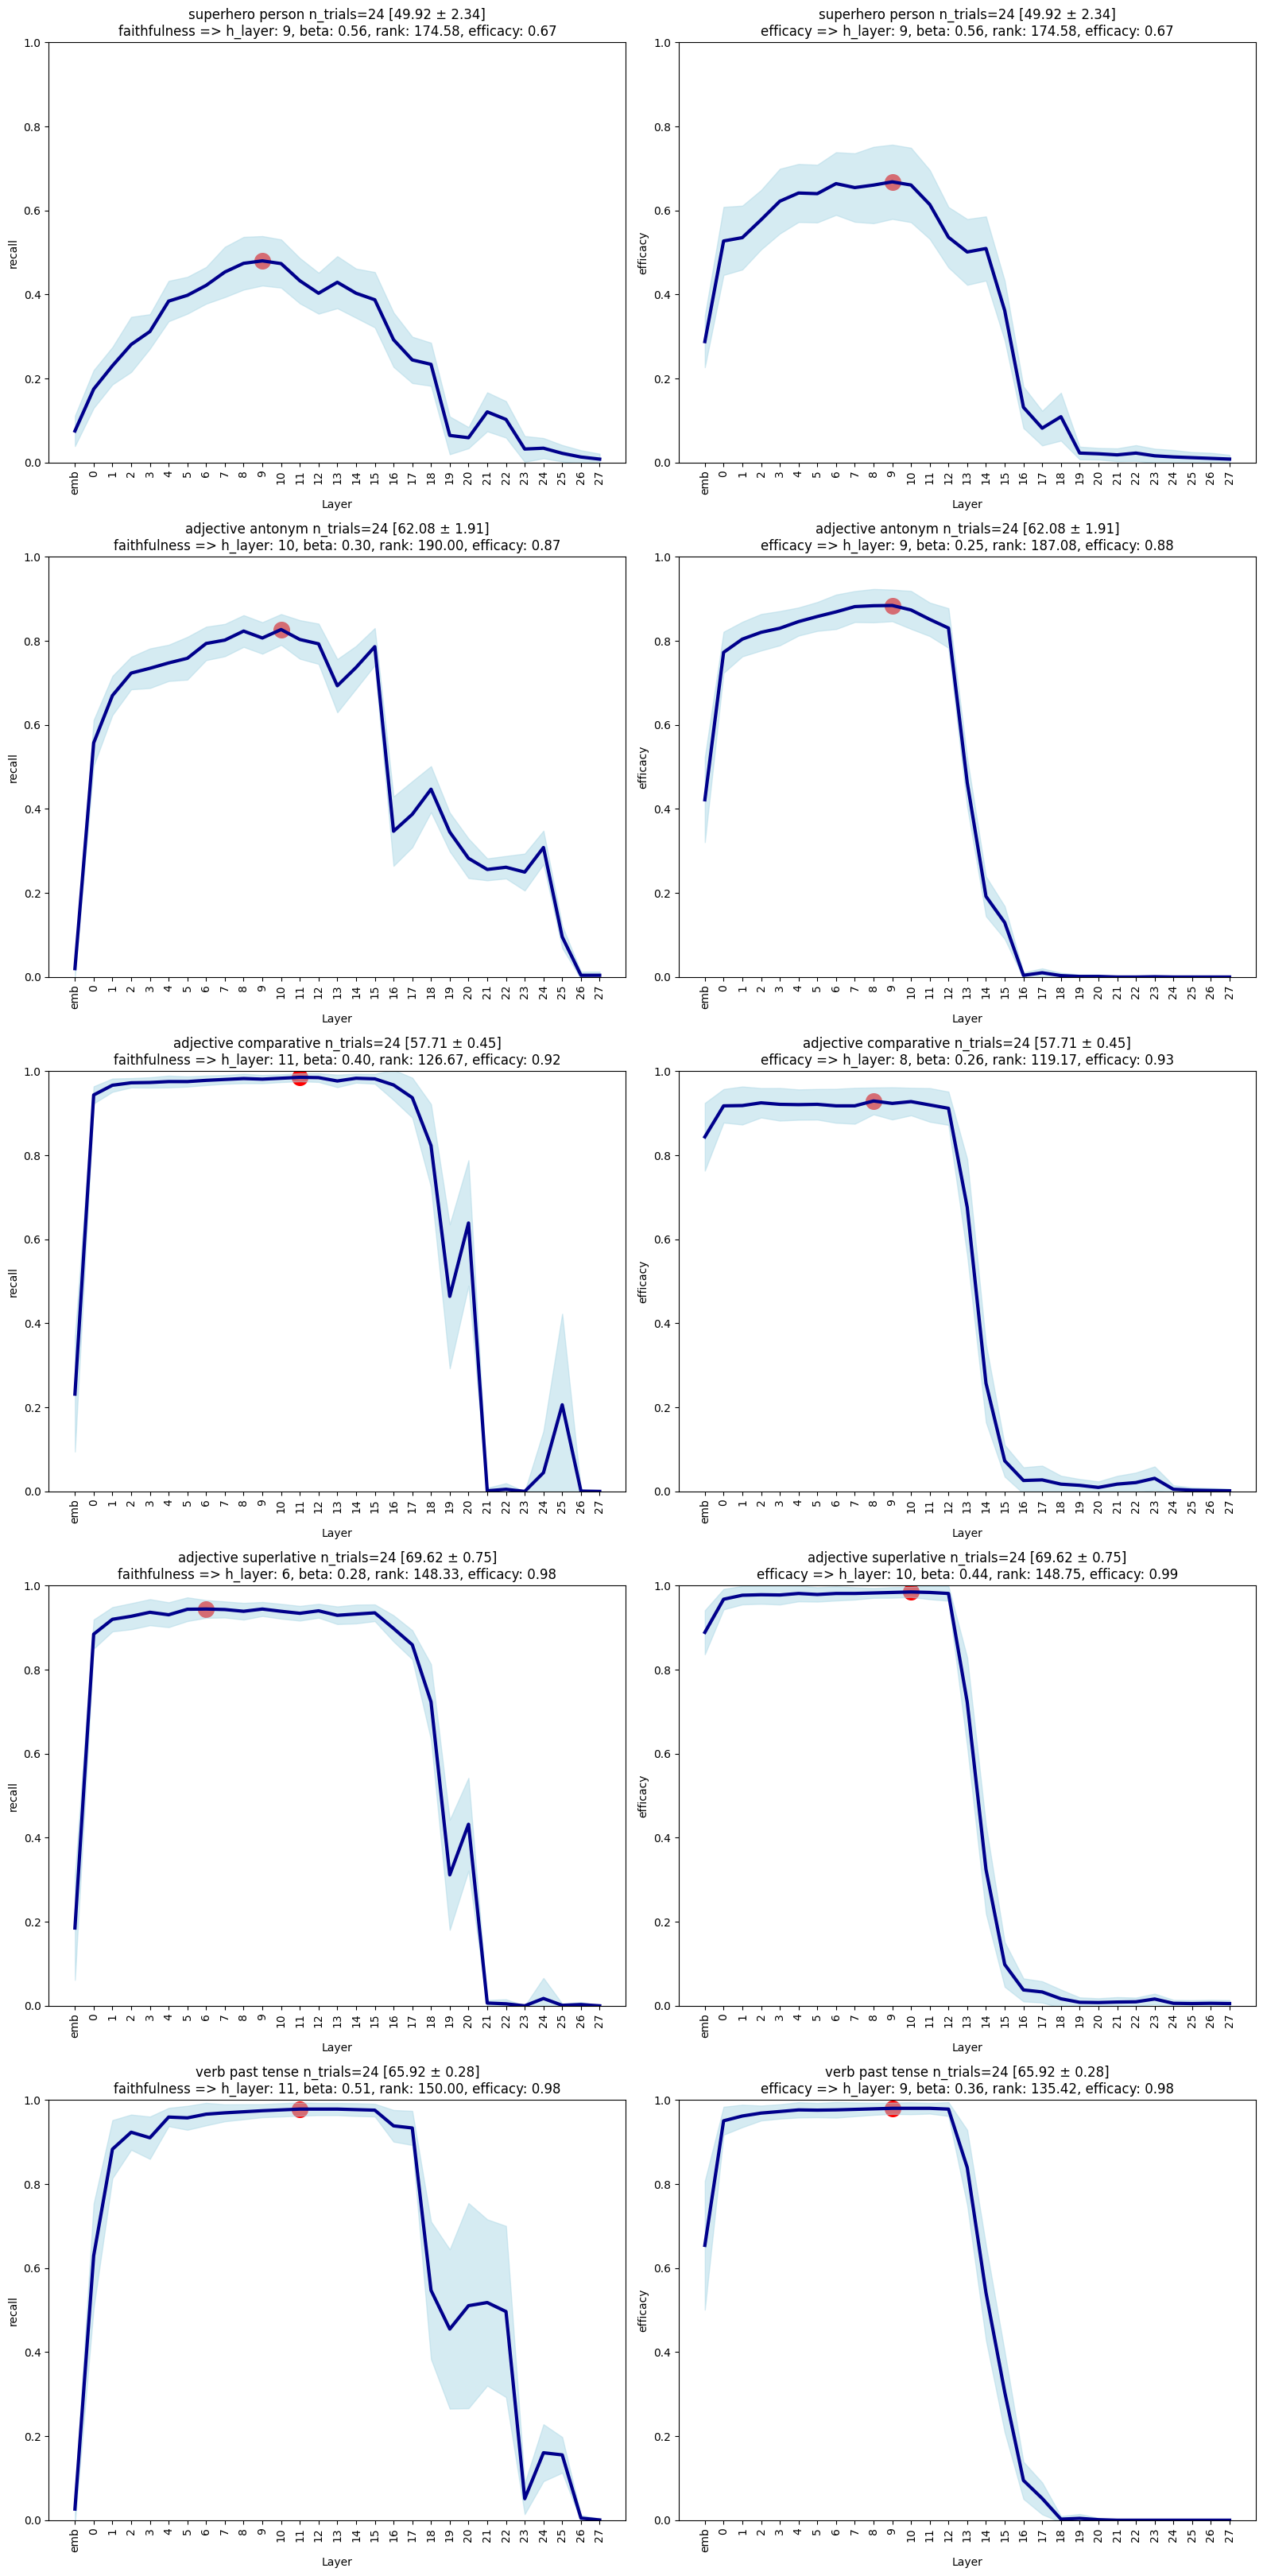

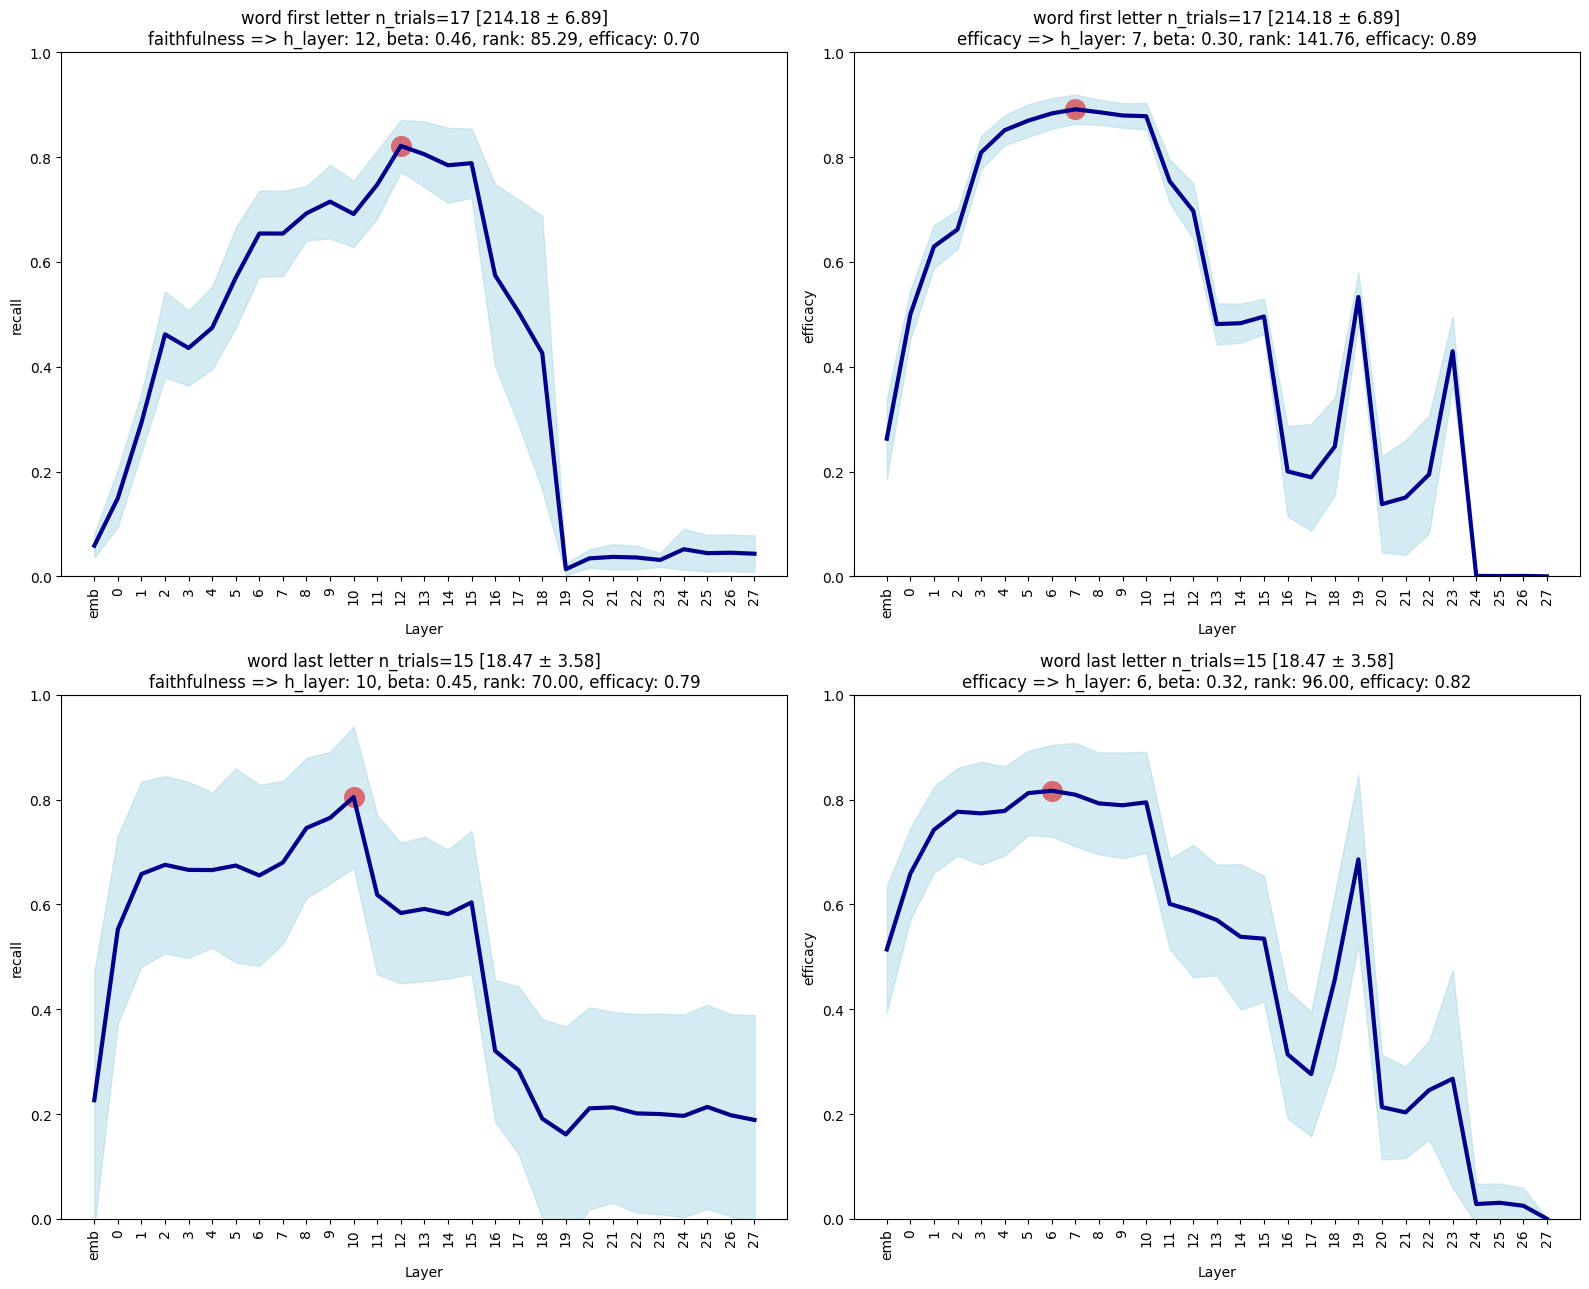

In [29]:
step_size = 5

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]
    if nrows == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        # result = parse_results(sweep_results[relation_name])
        result = filtered_results[relation_name]
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # if(relation_name in efficacy_baseline_results):
        #     efficacy_baselines = parse_efficacy_baseline_results(efficacy_baseline_results[relation_name])
        #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
        # plot_layerwise(axes[ax_row][2], result, attribute="jh_norm", best_criterion="efficacy")
        ax_row += 1
    fig.tight_layout()
    fig.show()

In [30]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30):
    recalls = []
    efficacies = []
    pass_threshold = []
    labels = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness().recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy().recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)
        labels.append(relation_name)

    return recalls, efficacies, pass_threshold, labels

/tmp/ipykernel_593859/2145924773.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


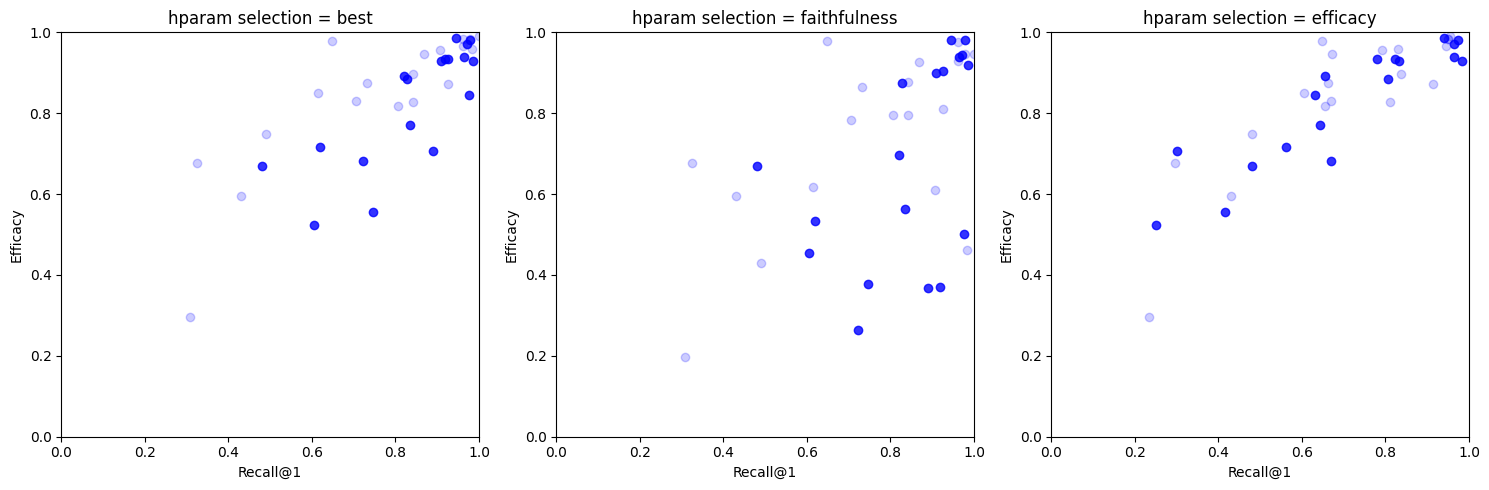

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion=criterion)
    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        ax.scatter(recall, efficacy, color="blue", alpha=alpha)
        # if threshold and (recall/efficacy < .7 or efficacy/recall < .7):
        #     ax.annotate(relation_name, (recall, efficacy))


    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [ ]:
def read_and_parse_sweep_results(sweep_path):
    sweep_results = read_sweep_results(sweep_path)
    for relation in sweep_results:
        sweep_results[relation] = parse_results(sweep_results[relation])
    return sweep_results

In [ ]:
sweep_single_path = f"../../results/sweep-single/{model_name}"
sweep_single = read_and_parse_sweep_results(sweep_single_path)

sweep_multi_path = f"../../results/sweep-multi/{model_name}"
sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    single_recalls, single_efficacies, pass_single, single_labels = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
    multi_recalls, multi_efficacies, pass_multi, multi_labels = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
    labeled = False
    for r, e, p, l in zip(single_recalls, single_efficacies, pass_single, single_labels):
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "blue", alpha = alpha)
        if p and (r/e < .7 or e/r < .7):
            ax.annotate(l, (r, e))

    labeled = False
    for r, e, p, l in zip(multi_recalls, multi_efficacies, pass_multi, multi_labels):
        alpha = .8 if p else 0.2
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)
        if p and (r/e < .7 or e/r < .7):
            ax.annotate(l, (r, e))

    ax.set_title(f"Efficacy vs Recall ({criterion})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Efficacy")
    ax.legend()

In [ ]:
from src import models

In [ ]:
mt = models.load_model(name = "gptj", fp16=True, device="cuda")

In [ ]:
mt.tokenizer(" :")